# 1. Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import shap # библиотека для анализа признаков
import optuna # библиотека для поиска гиперпараметров

from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

# 2. EDA
#### Контекст:
Нужно научиться моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. В данном соревновании решения будут сравниваться по метрике **ROC-AUC**.  
  
`ClientPeriod` - Количество месяцев, сколько клиент пользуется услугами компании.  
`MonthlySpending` - Стоимость месячного тарифа.  
`TotalSpent` - Общая сумма, которую клиент потратил за все время обслуживания.  
`Sex` - Пол клиента.  
`IsSeniorCitizen` - Является ли клиент пожилым человеком.  
`HasPartner` - Есть ли у клиента партнер.  
`HasChild` - Есть ли у клиента дети.  
`HasPhoneService` - Подключена ли у клиента телефонная связь.  
`HasMultiplePhoneNumbers` - Есть ли у клиента несколько телефонных номеров.  
`HasInternetService` - Подключен ли у клиента интернет.  
`HasOnlineSecurityService` - Подключена ли у клиента услуга онлайн-защиты.  
`HasOnlineBackup` - Есть ли у клиента услуга онлайн-резервного копирования.  
`HasDeviceProtection` - Подключена ли у клиента услуга защиты устройства.  
`HasTechSupportAccess` - Есть ли у клиента доступ к технической поддержке.  
`HasOnlineTV` - Подключена ли у клиента услуга онлайн-ТВ.  
`HasMovieSubscription` - Подключена ли у клиента подписка на кинотеатры.  
`HasContractPhone` - Период действия тарифа.  
`IsBillingPaperless` - Использует ли клиент безбумажную систему счетов.  
`PaymentMethod` - Способ оплаты, который выбирает клиент.  
`Churn` - Целевая переменная, которая показывает, ушел ли клиент или нет.

In [3]:
data = pd.read_csv('../input/advanced-dls-spring-2021/train.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Посмотрим, есть ли дубликаты

In [4]:
data.duplicated().sum()


14

In [5]:
data[data.duplicated()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1384,1,69.90,69.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
1474,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1636,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1959,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
2036,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
2586,1,20.20,20.2,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1
2877,1,70.10,70.1,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
2991,1,20.90,20.9,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3660,1,20.45,20.45,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
3749,1,20.20,20.2,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0


In [6]:
data = data.drop_duplicates().reset_index(drop=True)

In [7]:
data.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

In [8]:
print(data.shape)
data.info()

(5268, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   object 
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 1

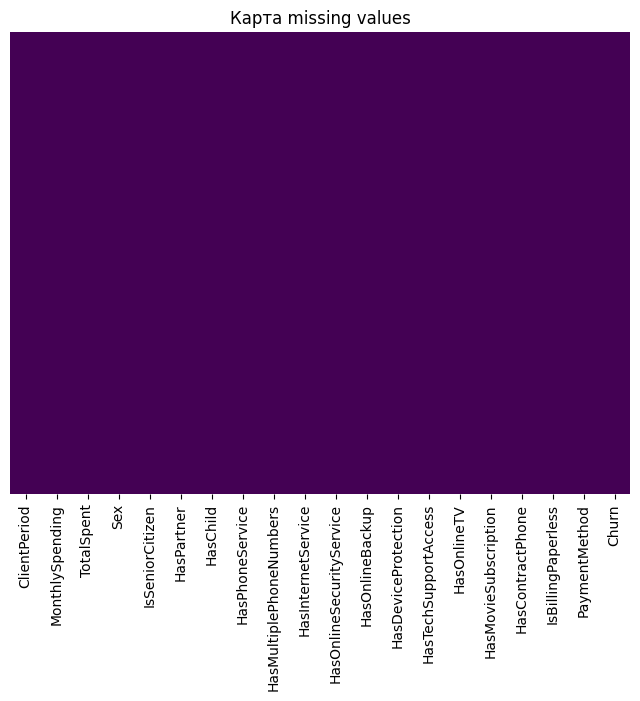

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', yticklabels=False)  
plt.title("Карта missing values")
plt.show()

Пропусков нет. Повезло, повезло...

Взглянув на описание столбцов, я могу отметить, что у нас есть столбцы `ClientPeriod`, `MonthlySpending` и `TotalSpent`. Нужно убедиться, что эти значения на прямую не связаны. (`ClientPeriod` * `MonthlySpending` != `TotalSpent`). Более того столбец `TotalSpent` почему-то имеет тип *`object`*. Надо взглянуть на него:

In [10]:
data['TotalSpent']

0       1026.35
1        1872.2
2          75.9
3          2570
4       6758.45
         ...   
5263      82.15
5264    2188.45
5265      55.05
5266    2215.25
5267     1375.6
Name: TotalSpent, Length: 5268, dtype: object

Попробуем конвертировать его во *`float`*

In [11]:
data['TotalSpent'] = data['TotalSpent'].astype(str).apply(lambda x: x.strip())
data['floatTotalSpent'] = pd.to_numeric(data['TotalSpent'])
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,floatTotalSpent
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0,1026.35
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,1872.20
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1,75.90
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0,2570.00
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0,6758.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0,82.15
5264,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0,2188.45
5265,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0,55.05
5266,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0,2215.25


In [12]:
data['floatTotalSpent'].isna().sum()

9

Появились пропуски в новом столбце. Надо будет избавиться от них. Скорее всего заполним медианой каждого класса, так как пропусков всего 9

In [13]:
data['newTotalSpent'] = data['ClientPeriod'] * data['MonthlySpending']
display(data[['newTotalSpent', 'floatTotalSpent']])
data[['newTotalSpent', 'floatTotalSpent']].describe()

,newTotalSpent,floatTotalSpent
0,1072.50,1026.35
1,1861.20,1872.20
2,75.90,75.90
3,2537.60,2570.00
4,6915.00,6758.45
...,...,...
5263,91.20,82.15
5264,2222.50,2188.45
5265,55.05,55.05
5266,2204.00,2215.25


,newTotalSpent,floatTotalSpent
count,5268.000000,5259.000000
mean,2294.070235,2297.370441
std,2268.254028,2269.066122
min,0.000000,18.800000
25%,397.487500,403.775000
50%,1407.600000,1415.000000
75%,3798.612500,3816.625000
max,8550.000000,8684.800000


Хорошая новость - столбцы независемы.

In [14]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'floatTotalSpent',
    'IsSeniorCitizen',
    'Churn'
]

cat_cols = [
    'Sex',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target = 'Churn'

In [15]:
data[num_cols].describe()

,ClientPeriod,MonthlySpending,floatTotalSpent,IsSeniorCitizen,Churn
count,5268.000000,5268.000000,5259.000000,5268.000000,5268.000000
mean,32.480448,64.977563,2297.370441,0.159643,0.260820
std,24.529439,30.176025,2269.066122,0.366310,0.439124
min,0.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.537500,403.775000,0.000000,0.000000
50%,29.000000,70.450000,1415.000000,0.000000,0.000000
75%,55.000000,90.050000,3816.625000,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


Сразу можно сказать, что балансом классов и не пахнет ( mean целевого признака: 0.26)

In [16]:
print(data[cat_cols].describe(include=['O']))

         Sex HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
count   5268       5268     5268            5268                    5268   
unique     2          2        2               2                       3   
top     Male         No       No             Yes                      No   
freq    2647       2691     3662            4747                    2497   

       HasInternetService HasOnlineSecurityService HasOnlineBackup  \
count                5268                     5268            5268   
unique                  3                        3               3   
top           Fiber optic                       No              No   
freq                 2335                     2604            2324   

       HasDeviceProtection HasTechSupportAccess HasOnlineTV  \
count                 5268                 5268        5268   
unique                   3                    3           3   
top                     No                   No          No   
freq            

Важно отметить, что признаки, например, `HasInternetService`, `HasMultiplePhoneNumbers`, которые по идее должны иметь 2 значения, имеют 3, необходимо их проанализировать. Очень много бинарных признаков и признаков с малым количеством уникальных значений.

In [17]:
data.nunique()

ClientPeriod                  73
MonthlySpending             1468
TotalSpent                  4978
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
Churn                          2
floatTotalSpent             4977
newTotalSpent               4692
dtype: int64

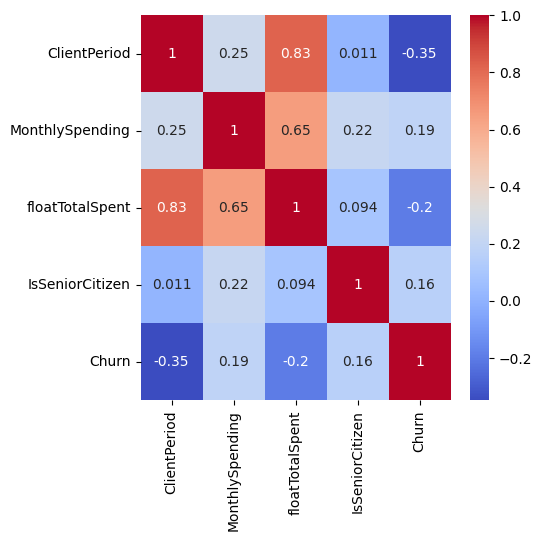

In [18]:
plt.figure(figsize=(5, 5))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

По матрице корреляций понятно, что нет признаков, коррелирующих между собой, поэтому не будем ничего удалять на этом этапе. Изучим потенциальную важность признаков(насколько они коррелируют с целевой переменной). В топе оказался `ClientPeriod`

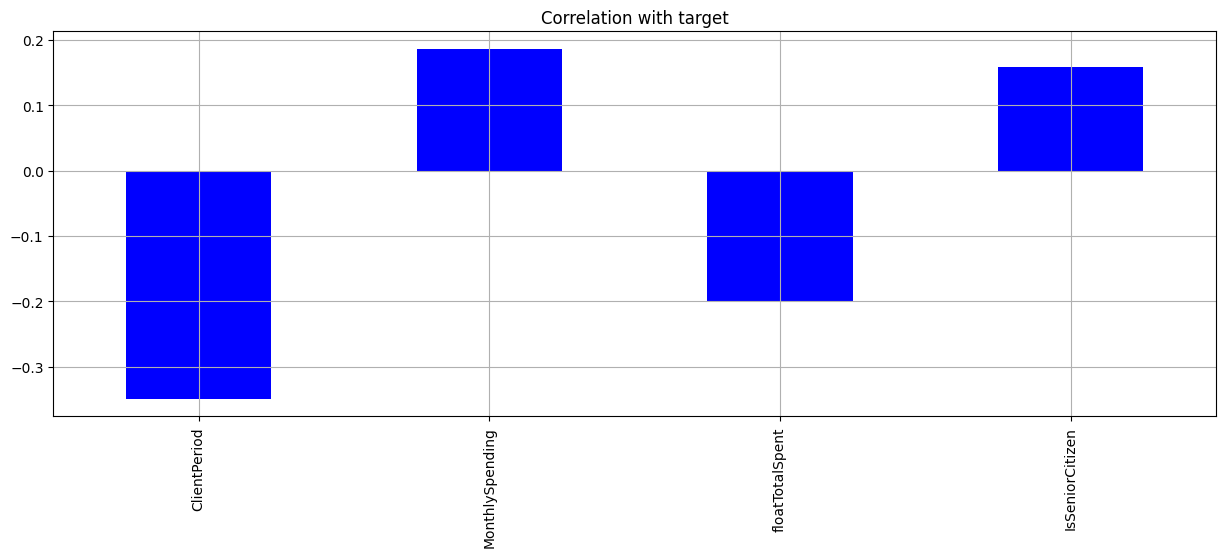

In [19]:
data[num_cols].drop('Churn', axis=1).corrwith(data['Churn']).plot(kind='bar', grid=True, figsize=(15, 5), 
                                                        title="Correlation with target",
                                                        color="Blue");

## Number columns
Посмотрим на диапазон и распределение каждого num признака

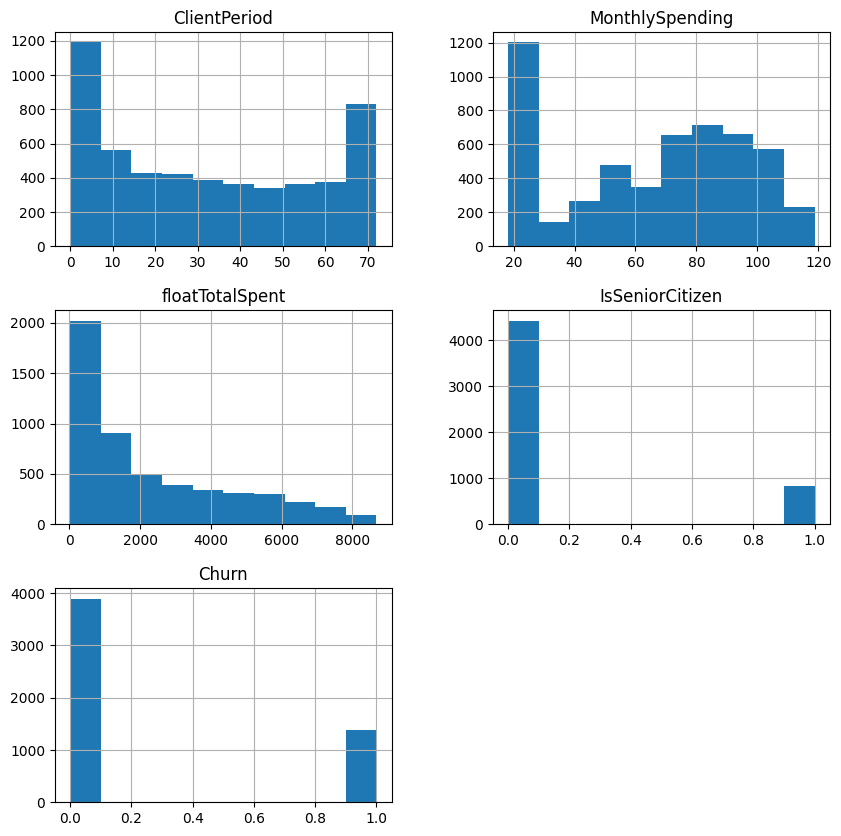

In [20]:
data[num_cols].hist(figsize=(10, 10))
plt.show()

Как и предполагали, **баланс классов нарушен**. Добавим на графики *`mean`*, *`median`*, *`mode`*

In [21]:
def generate_distribution_plot(df_train, continuous_features, figsize=(15, 10)):
    data = df_train[continuous_features].copy()
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=figsize)
    fig.subplots_adjust(hspace=0.7)

    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

    for ax, feature in zip(axes.flatten(), data.columns):
        feature_mean = data[feature].mean()
        feature_median = data[feature].median()
        feature_mode = data[feature].mode().values[0]
        sns.distplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
        ax.axvline(feature_mean, color='r', linestyle='--', label="Mean")
        ax.axvline(feature_median, color='g', linestyle='-', label="Median")
        ax.axvline(feature_mode, color='b', linestyle='-', label="Mode")
        ax.legend()
    plt.show()

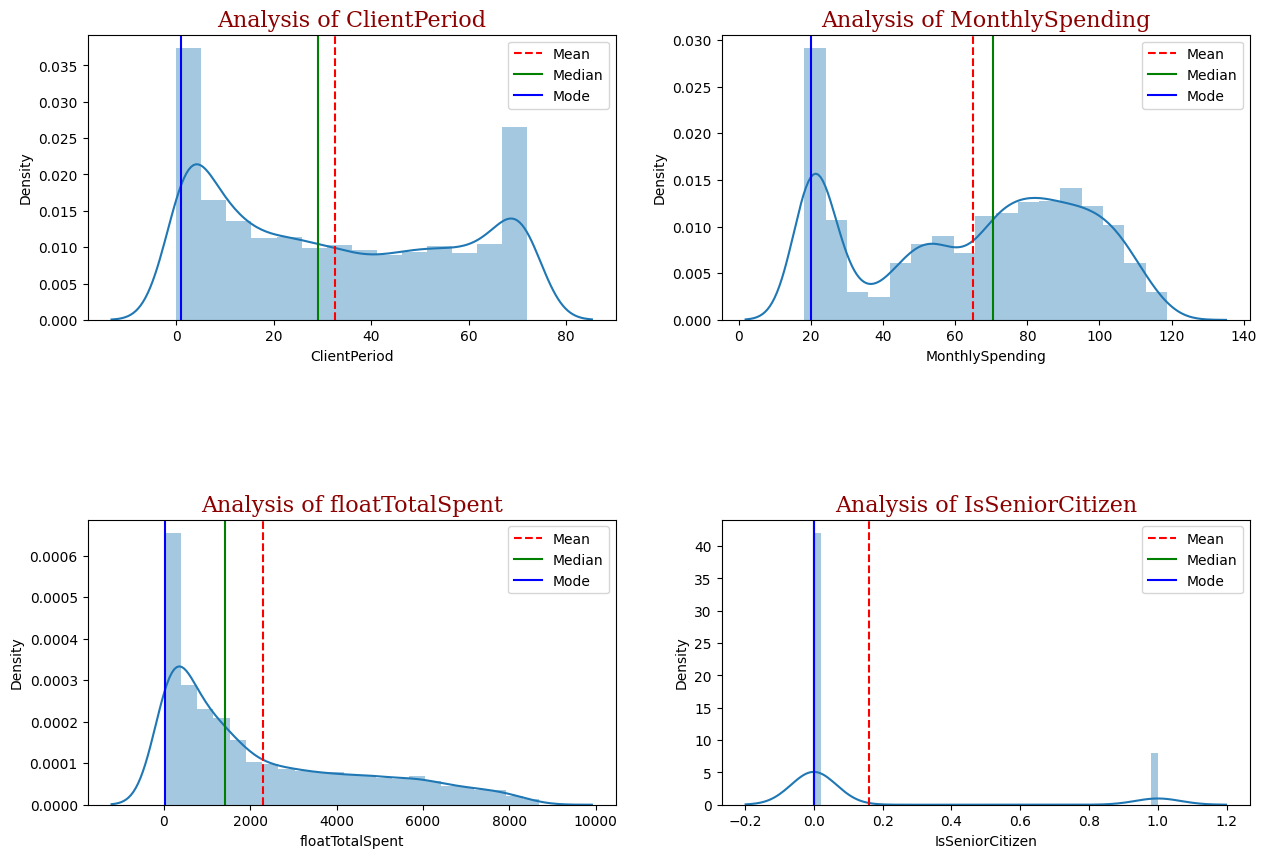

In [22]:
generate_distribution_plot(data, num_cols)

**Результаты анализа:** 
- Двухпиковое распределение `MonthlySpending` указывает на наличие двух групп клиентов.  
- Сильное смещение влево в `floatTotalSpent` показывает, что большинство клиентов тратят не так много за весь период, и существует длинный "хвост" клиентов, которые потратили значительно больше.

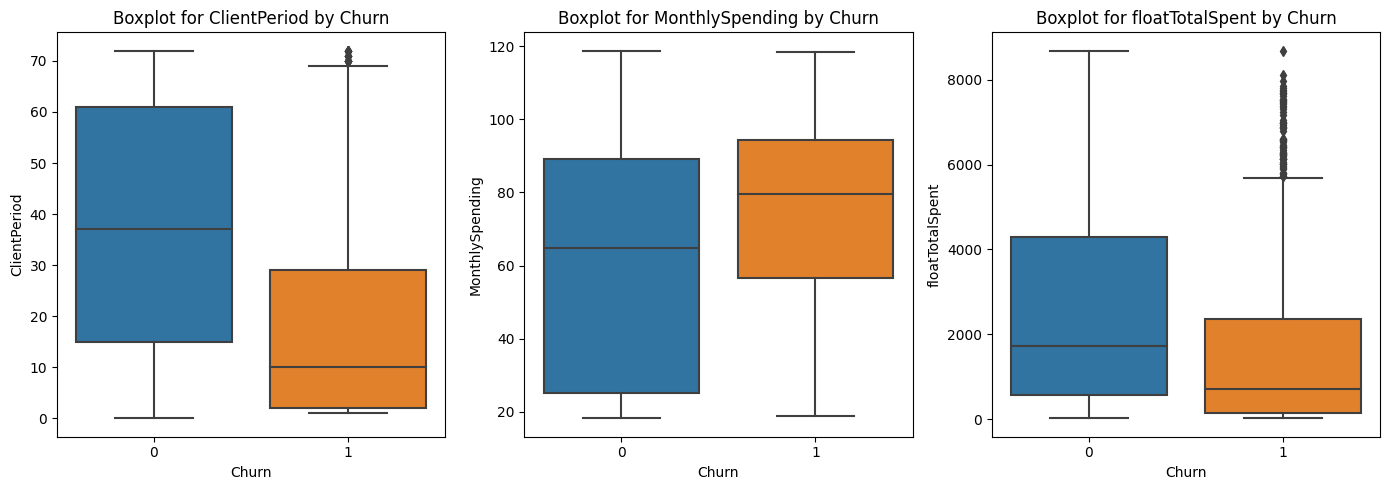

In [23]:
ncols = ['ClientPeriod', 'MonthlySpending', 'floatTotalSpent']

plt.figure(figsize=(14, 5))

for i, col in enumerate(ncols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=data)
    plt.title(f'Boxplot for {col} by Churn')
    plt.tight_layout()
plt.show()

**Результаты анализа:** 
- Клиенты, которые остались (`Churn` = 0), имеют значительно больший период обслуживания в компании, чем те, кто ушли (`Churn` = 1). 
- Еще стоит отметить, что разница в расходах между оставшимися и ушедшими клиентами не такая явная, но можно заметить, что у ушедших клиентов медиана расходов немного выше.  

**Дальнейшие планы:** Можно создать признаки, указывающие на долгосрочных клиентов , уровни трат, например, выше или ниже медианных значений `MonthlySpending` и `floatTotalSpent`. Также необходимо будет выровнить распределения у `floatTotalSpent` и `ClientPeriod`

## Categorical columns
Приступем к анализу категориальных признаков

In [24]:
def analyze_categorical_features(data, cat_cols, target_name):
    n_cols = 4
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for i, col in enumerate(cat_cols):
        sns.countplot(data=data, x=col, hue=target_name, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by {target_name}')
        axes[i].tick_params(axis='x', rotation=45)
        crosstab = pd.crosstab(data[col], data[target_name], normalize='index')
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

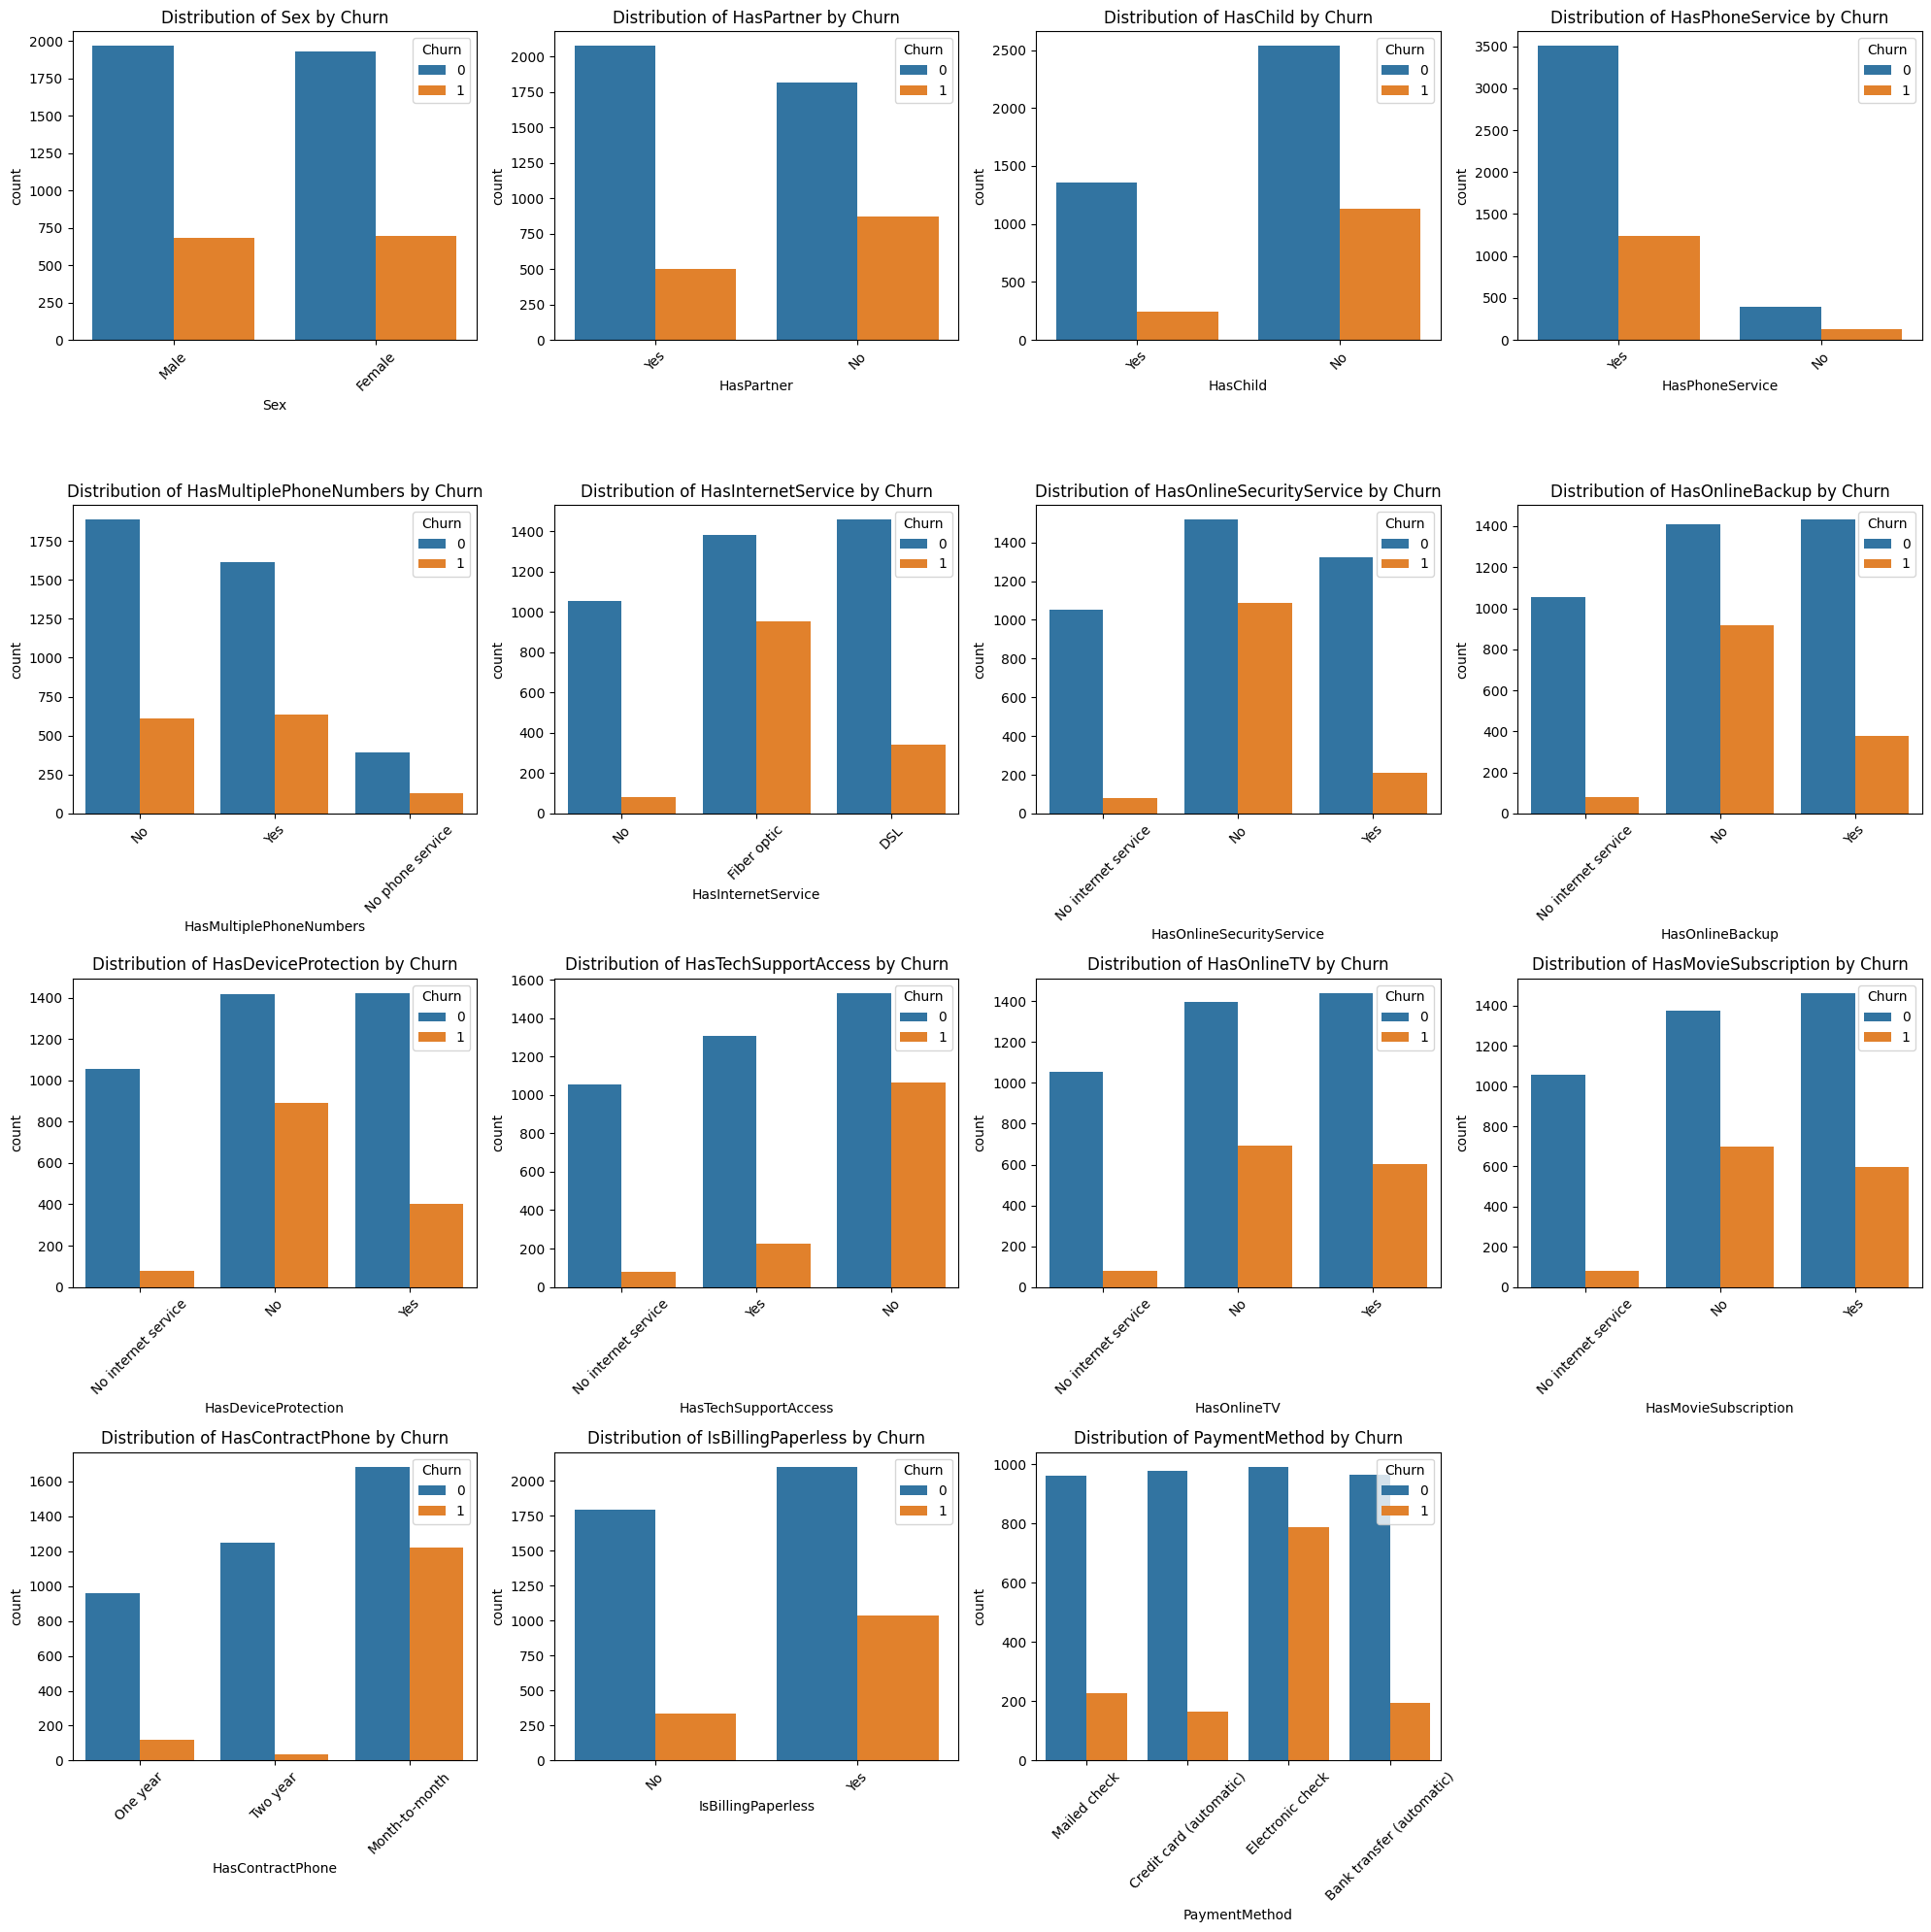

In [25]:
analyze_categorical_features(data, cat_cols, 'Churn')

**Результаты анализа:** 
 - Клиенты с короткими контрактами склонны чаще уходить.
 - Дополнительные услуги (онлайн-безопасность, техподдержка, бэкап) снижают вероятность оттока.
 - Клиенты без партнёров, без детей и с *`Fiber Optic`* интернетом также более склонны к оттоку.

# 3. Data Cleaning

## Избавимся от Nan значений
Заполним пропуски в `floatTotalSpent` значением *`median`* каждого из класса

In [26]:
data[data['floatTotalSpent'].isna()][['TotalSpent', 'floatTotalSpent']]

,TotalSpent,floatTotalSpent
1048,,NaN
1704,,NaN
2538,,NaN
3070,,NaN
3688,,NaN
3992,,NaN
4315,,NaN
4538,,NaN
4585,,NaN


In [27]:
median_churn_0 = data[data['Churn'] == 0]['floatTotalSpent'].median()
median_churn_1 = data[data['Churn'] == 1]['floatTotalSpent'].median()
data.loc[(data['Churn'] == 0) & (data['floatTotalSpent'].isnull()), 'floatTotalSpent'] = median_churn_0
data.loc[(data['Churn'] == 1) & (data['floatTotalSpent'].isnull()), 'floatTotalSpent'] = median_churn_1
data['floatTotalSpent'].isna().sum()

0

## Удаление ненужных столбцов

In [28]:
data.drop(['newTotalSpent', 'TotalSpent'], axis=1, inplace=True)

# 4. Data Preparation

## Feature engineering 
Создадим новые бинарные признаки из признаков `ClientPeriod`, `MonthlySpending`, `floatTotalSpent` 

In [29]:
def create_new_binary_feature(data, feature_name, new_name, splitter_type='median'):
    if splitter_type == 'mean':
        c = data[feature_name].mean()
    else:
        split_value = data[feature_name].median()
    
    data[new_name] = data[feature_name] >= split_value
    data[new_name] = data[new_name].astype(int)

In [30]:
create_new_binary_feature(data, 'ClientPeriod', 'LongTermClient')
create_new_binary_feature(data, 'MonthlySpending', 'HighMonthlySpending')
create_new_binary_feature(data, 'floatTotalSpent', 'HighTotalSpent')

In [31]:
data.head()

,ClientPeriod,MonthlySpending,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,floatTotalSpent,LongTermClient,HighMonthlySpending,HighTotalSpent
0,55,19.50,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0,1026.35,1,0,0
1,72,25.85,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,1872.20,1,0,1
2,1,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1,75.90,0,1,0
3,32,79.30,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0,2570.00,1,1,1
4,60,115.25,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0,6758.45,1,1,1


## Data preprocessing
- Исправим распределение числовых признаков, используя логарифмическое преобразование. 
- Переведем значения бинарных в 0 и 1 
- Используем OHE для мультиклассовых признаков

In [32]:
cat_boost_data = data.copy()

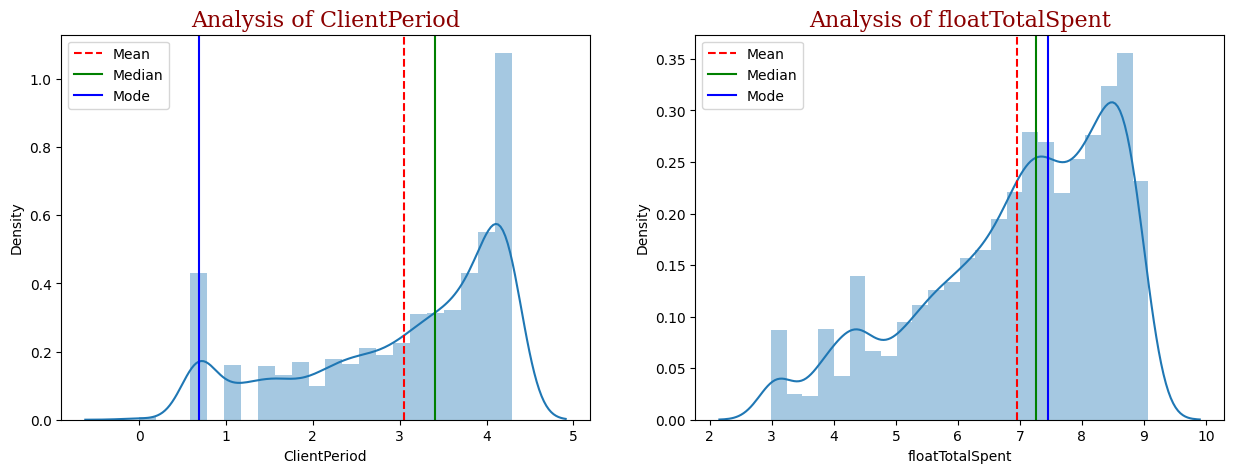

In [33]:
data['ClientPeriod'] = np.log1p(data['ClientPeriod'])
data['floatTotalSpent'] = np.log1p(data['floatTotalSpent'])
generate_distribution_plot(data, ['ClientPeriod', 'floatTotalSpent'], figsize=(15, 5))

In [34]:
binary_cols = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'IsBillingPaperless']
data[binary_cols] = data[binary_cols].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})
data.head()

,ClientPeriod,MonthlySpending,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,floatTotalSpent,LongTermClient,HighMonthlySpending,HighTotalSpent
0,4.025352,19.50,1,0,1,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,0,6.934738,1,0,0
1,4.290459,25.85,1,0,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),0,7.535403,1,0,1
2,0.693147,75.90,1,0,0,0,1,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,1,Electronic check,1,4.342506,0,1,0
3,3.496508,79.30,0,1,1,0,1,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,0,Mailed check,0,7.852050,1,1,1
4,4.110874,115.25,0,0,1,1,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,0,Credit card (automatic),0,8.818697,1,1,1


In [35]:
columns = data.columns[(data.dtypes == 'object') & (data.nunique() > 2)]

ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
ohe_columns = ohe.fit_transform(data[columns])
ohe_column_names = ohe.get_feature_names_out(columns)
ohe_df = pd.DataFrame(ohe_columns, columns=ohe_column_names)

data = data.drop(columns, axis=1)
data = pd.concat([data, ohe_df], axis=1)
display(data.shape)
data.head()

(5268, 34)

,ClientPeriod,MonthlySpending,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,Churn,floatTotalSpent,LongTermClient,HighMonthlySpending,HighTotalSpent,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,4.025352,19.50,1,0,1,1,1,0,0,6.934738,1,0,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4.290459,25.85,1,0,1,0,1,0,0,7.535403,1,0,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.693147,75.90,1,0,0,0,1,1,1,4.342506,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.496508,79.30,0,1,1,0,1,0,0,7.852050,1,1,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.110874,115.25,0,0,1,1,1,0,0,8.818697,1,1,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [36]:
y = data[target]
X = data.drop([target], axis=1)

y_cat = cat_boost_data[target]
X_cat = cat_boost_data.drop(target, axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

# 5. Models 

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_train = knn.predict_proba(X_train)[:, 1]
y_pred_test = knn.predict_proba(X_test)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print("Roc Auc train: %.4f" % roc_auc_train)
print("Roc Auc test: %.4f" % roc_auc_test)

Roc Auc train: 0.9028
Roc Auc test: 0.7607


In [39]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred_train = decision_tree.predict_proba(X_train)[:, 1]
y_pred_test = decision_tree.predict_proba(X_test)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print("Roc Auc train: %.4f" % roc_auc_train)
print("Roc Auc test: %.4f" % roc_auc_test)

Roc Auc train: 1.0000
Roc Auc test: 0.6348


In [40]:
logistic_regression = LogisticRegression(C=1, penalty='l2', max_iter=2000)
logistic_regression.fit(X_train, y_train)

y_pred_train = logistic_regression.predict_proba(X_train)[:, 1]
y_pred_test = logistic_regression.predict_proba(X_test)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print("Roc Auc train: %.4f" % roc_auc_train)
print("Roc Auc test: %.4f" % roc_auc_test)

Roc Auc train: 0.8530
Roc Auc test: 0.8497


In [41]:
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

y_pred_train = svc.predict_proba(X_train)[:, 1]
y_pred_test = svc.predict_proba(X_test)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print("Roc Auc train: %.4f" % roc_auc_train)
print("Roc Auc test: %.4f" % roc_auc_test)

Roc Auc train: 0.8448
Roc Auc test: 0.8442


In [42]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, y_train)

y_pred_train = random_forest.predict_proba(X_train)[:, 1]
y_pred_test = random_forest.predict_proba(X_test)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print("Roc Auc train: %.4f" % roc_auc_train)
print("Roc Auc test: %.4f" % roc_auc_test)

Roc Auc train: 1.0000
Roc Auc test: 0.8199


# 6. Hyperparameters search

In [43]:
def optimize_logistic_regression(trial):
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba) 
    return roc_auc


study = optuna.create_study(direction='maximize')
study.optimize(optimize_logistic_regression, n_trials=50)

best_trial = study.best_trial
best_linear_params = best_trial.params
best_linear_model = LogisticRegression(**best_linear_params, random_state=42)
best_linear_model.fit(X_train, y_train)

y_pred_proba = best_linear_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Лучшие гиперпараметры: {best_linear_params}')
print(f'ROC AUC на тестовой выборке: {roc_auc:.4f}')


[I 2024-10-15 17:40:32,464] A new study created in memory with name: no-name-a390e106-02c2-42ef-9c43-d355064d766f
[I 2024-10-15 17:40:32,905] Trial 0 finished with value: 0.8482158066045771 and parameters: {'penalty': None, 'C': 0.0011407343980502542, 'max_iter': 720}. Best is trial 0 with value: 0.8482158066045771.
[I 2024-10-15 17:40:33,202] Trial 1 finished with value: 0.8485749011339101 and parameters: {'penalty': None, 'C': 1.868608017954277, 'max_iter': 420}. Best is trial 1 with value: 0.8485749011339101.
[I 2024-10-15 17:40:33,605] Trial 2 finished with value: 0.8481927877244916 and parameters: {'penalty': None, 'C': 1.4249250605968943e-05, 'max_iter': 585}. Best is trial 1 with value: 0.8485749011339101.
[I 2024-10-15 17:40:34,007] Trial 3 finished with value: 0.8482342217086455 and parameters: {'penalty': None, 'C': 0.006281028377597424, 'max_iter': 573}. Best is trial 1 with value: 0.8485749011339101.
[I 2024-10-15 17:40:34,081] Trial 4 finished with value: 0.844058596861145

Лучшие гиперпараметры: {'penalty': 'l2', 'C': 1144.7883914784431, 'max_iter': 103}
ROC AUC на тестовой выборке: 0.8506


In [44]:
def optimize_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, 
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(optimize_random_forest, n_trials=50)
best_trial = study.best_trial
best_tree_params = best_trial.params

best_tree_model = RandomForestClassifier(**best_tree_params, random_state=42)
best_tree_model.fit(X_train, y_train)

y_pred_proba = best_tree_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Лучшие гиперпараметры: {best_tree_params}')
print(f'ROC AUC на тестовой выборке: {roc_auc:.4f}')

[I 2024-10-15 17:40:44,797] A new study created in memory with name: no-name-ed35e1d4-74ce-4811-903c-22f8ed4e44a5
[I 2024-10-15 17:40:46,423] Trial 0 finished with value: 0.844445314046581 and parameters: {'n_estimators': 355, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.844445314046581.
[I 2024-10-15 17:40:47,730] Trial 1 finished with value: 0.8403755760474741 and parameters: {'n_estimators': 262, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.844445314046581.
[I 2024-10-15 17:40:48,610] Trial 2 finished with value: 0.8452417672975376 and parameters: {'n_estimators': 186, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8452417672975376.
[I 2024-10-15 17:40:50,408] Trial 3 finished with value: 0.843050369913403 and parameters: {'n_estimators': 363, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.

Лучшие гиперпараметры: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}
ROC AUC на тестовой выборке: 0.8460


# 7. Ensemble

## CatBoost

In [45]:
def optimize_catboost(trial):
    iterations = trial.suggest_int('iterations', 100, 400)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    depth = trial.suggest_int('depth', 1, 3)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e5)

    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=0
    )

    model.fit(X_train_cat, y_train_cat, cat_features=cat_cols)

    y_pred_proba = model.predict_proba(X_test_cat)[:, 1]
    roc_auc = roc_auc_score(y_test_cat, y_pred_proba)

    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(optimize_catboost, n_trials=50)

best_trial = study.best_trial
best_params = best_trial.params

best_model = CatBoostClassifier(**best_params, random_state=42)
best_model.fit(X_train_cat, y_train_cat, cat_features=cat_cols)
y_pred_proba = best_model.predict_proba(X_test_cat)[:, 1]
roc_auc = roc_auc_score(y_test_cat, y_pred_proba)


print(f'Лучшие гиперпараметры: {best_params}')
print(f'ROC AUC на тестовой выборке: {roc_auc:.4f}')

[I 2024-10-15 17:41:27,824] A new study created in memory with name: no-name-87fb180f-c9e9-4a80-9d70-ef5149c985ca
[I 2024-10-15 17:41:28,812] Trial 0 finished with value: 0.8295083627591351 and parameters: {'iterations': 192, 'learning_rate': 0.014814670153254503, 'depth': 2, 'l2_leaf_reg': 1883.4426934296478}. Best is trial 0 with value: 0.8295083627591351.
[I 2024-10-15 17:41:30,270] Trial 1 finished with value: 0.8444476159345896 and parameters: {'iterations': 227, 'learning_rate': 0.020092561561691286, 'depth': 3, 'l2_leaf_reg': 1.653590563601943e-05}. Best is trial 1 with value: 0.8444476159345896.
[I 2024-10-15 17:41:31,959] Trial 2 finished with value: 0.8450230879367256 and parameters: {'iterations': 359, 'learning_rate': 0.024952820714461876, 'depth': 2, 'l2_leaf_reg': 0.00014594214385706066}. Best is trial 2 with value: 0.8450230879367256.
[I 2024-10-15 17:41:32,450] Trial 3 finished with value: 0.798239516051065 and parameters: {'iterations': 115, 'learning_rate': 0.00275848

0:	learn: 0.6770919	total: 7.27ms	remaining: 2.24s
1:	learn: 0.6618546	total: 13.9ms	remaining: 2.13s
2:	learn: 0.6485341	total: 20.2ms	remaining: 2.06s
3:	learn: 0.6319355	total: 27.1ms	remaining: 2.06s
4:	learn: 0.6189381	total: 32.6ms	remaining: 1.98s
5:	learn: 0.6056857	total: 38.4ms	remaining: 1.94s
6:	learn: 0.5941013	total: 44.7ms	remaining: 1.93s
7:	learn: 0.5825869	total: 50ms	remaining: 1.88s
8:	learn: 0.5718778	total: 56.9ms	remaining: 1.9s
9:	learn: 0.5617954	total: 63ms	remaining: 1.88s
10:	learn: 0.5524957	total: 69.6ms	remaining: 1.89s
11:	learn: 0.5439728	total: 75.6ms	remaining: 1.87s
12:	learn: 0.5368750	total: 81.3ms	remaining: 1.85s
13:	learn: 0.5293936	total: 88.1ms	remaining: 1.85s
14:	learn: 0.5227517	total: 94.6ms	remaining: 1.85s
15:	learn: 0.5161785	total: 100ms	remaining: 1.84s
16:	learn: 0.5100389	total: 106ms	remaining: 1.82s
17:	learn: 0.5049633	total: 113ms	remaining: 1.82s
18:	learn: 0.5006251	total: 121ms	remaining: 1.84s
19:	learn: 0.4957037	total: 128

## Xgboost

In [46]:
def optimize_xgboost(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    gamma = trial.suggest_loguniform('gamma', 0.01, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 1.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 1.0)

    model = xgb.XGBClassifier(
        max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
        gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=42
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(optimize_xgboost, n_trials=50)

best_trial = study.best_trial
best_params = best_trial.params
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Лучшие гиперпараметры: {best_params}')
print(f'ROC AUC на тестовой выборке: {roc_auc:.4f}')


[I 2024-10-15 17:42:48,741] A new study created in memory with name: no-name-5fe20379-e425-4d79-a885-3ad749abe239
[I 2024-10-15 17:42:48,903] Trial 0 finished with value: 0.8339924405997798 and parameters: {'max_depth': 7, 'learning_rate': 0.1368601400859734, 'n_estimators': 55, 'gamma': 0.32092846669146163, 'subsample': 0.6110779064627775, 'colsample_bytree': 0.7801913634110447, 'reg_alpha': 0.04224690065222398, 'reg_lambda': 0.9347189353795585}. Best is trial 0 with value: 0.8339924405997798.
[I 2024-10-15 17:42:49,135] Trial 1 finished with value: 0.8215760566816903 and parameters: {'max_depth': 6, 'learning_rate': 0.1619232791431096, 'n_estimators': 136, 'gamma': 0.10157983899807065, 'subsample': 0.5888353366124028, 'colsample_bytree': 0.8175376266867513, 'reg_alpha': 0.013553189483436515, 'reg_lambda': 0.7337719705919743}. Best is trial 0 with value: 0.8339924405997798.
[I 2024-10-15 17:42:49,288] Trial 2 finished with value: 0.7910783424564828 and parameters: {'max_depth': 4, 'le

Лучшие гиперпараметры: {'max_depth': 3, 'learning_rate': 0.03173328330252941, 'n_estimators': 162, 'gamma': 0.012768719560783334, 'subsample': 0.9075859160629872, 'colsample_bytree': 0.7941333918940798, 'reg_alpha': 0.956684209402877, 'reg_lambda': 0.33219455584645097}
ROC AUC на тестовой выборке: 0.8493


# 8. Feature selection

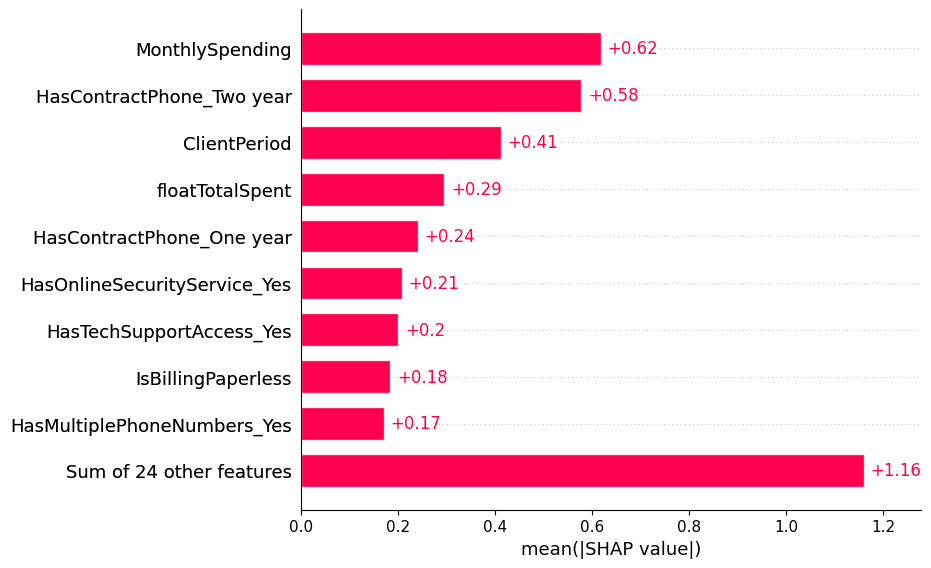

In [47]:
explainer = shap.Explainer(best_linear_model, X_train)

shap_values = explainer(X_test)
shap_values_0 = shap_values[:, :, 0]
shap.plots.bar(shap_values_0)

# 9. Submit

In [48]:
test_data = pd.read_csv('../input/advanced-dls-spring-2021/test.csv')
test_data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
1757,13,20.85,272.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1758,2,91.45,171.45,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check
1759,19,89.10,1620.8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check


In [49]:
test_data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

In [50]:
test_data['TotalSpent'] = test_data['TotalSpent'].astype(str).apply(lambda x: x.strip())
test_data['floatTotalSpent'] = pd.to_numeric(test_data['TotalSpent'])

median_churn = test_data['floatTotalSpent'].median()
test_data.loc[test_data['floatTotalSpent'].isnull(), 'floatTotalSpent'] = median_churn

test_data.drop('TotalSpent', axis=1, inplace=True)

create_new_binary_feature(test_data, 'ClientPeriod', 'LongTermClient')
create_new_binary_feature(test_data, 'MonthlySpending', 'HighMonthlySpending')
create_new_binary_feature(test_data, 'floatTotalSpent', 'HighTotalSpent')

## LinearModel

In [51]:
test_data['ClientPeriod'] = np.log1p(test_data['ClientPeriod'])
test_data['floatTotalSpent'] = np.log1p(test_data['floatTotalSpent'])

binary_cols = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'IsBillingPaperless']
test_data[binary_cols] = test_data[binary_cols].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

columns = test_data.columns[(test_data.dtypes == 'object') & (test_data.nunique() > 2)]

test_ohe_columns = ohe.transform(test_data[columns])
ohe_df = pd.DataFrame(test_ohe_columns, columns=ohe_column_names)

test_data = test_data.drop(columns, axis=1)
test_data = pd.concat([test_data, ohe_df], axis=1)

In [52]:
test_pred_proba = best_linear_model.predict_proba(test_data)[:, 1]

In [53]:
submission = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = test_pred_proba

In [54]:
submission.to_csv("new_submission.csv", index=False)

## CatBoost